In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

data1 = pd.read_excel(r"C:\Users\ADMIN\Downloads\DSTC V3\VNINDEX_cleaned.xlsx")
data1 = data1.drop("Unnamed: 0", axis =1)
data2 = pd.read_excel(r"C:\Users\ADMIN\Downloads\DSTC V3\HNXINDEX_cleaned.xlsx")
data2 = data2.drop("Unnamed: 0", axis =1)
data3 = pd.read_excel(r"C:\Users\ADMIN\Downloads\DSTC V3\UPCOM_cleaned.xlsx")
data3 = data3.drop("Unnamed: 0", axis =1)
data = pd.concat([data1, data2, data3], ignore_index=True)
data.info()

output_csv = r"C:\Users\ADMIN\Downloads\DSTC V3\AllIndex_cleaned.csv"
data.to_csv(output_csv, index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330513 entries, 0 to 330512
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   exchange         330513 non-null  object 
 1   ticker           330513 non-null  object 
 2   timestamp        330513 non-null  object 
 3   open             330513 non-null  float64
 4   high             330513 non-null  float64
 5   low              330513 non-null  float64
 6   close            330513 non-null  float64
 7   volume           330513 non-null  int64  
 8   ema_50           330513 non-null  float64
 9   ema_200          330513 non-null  float64
 10  macd             330513 non-null  float64
 11  macd_signal      330513 non-null  float64
 12  macd_diff        330513 non-null  float64
 13  rsi              330513 non-null  float64
 14  bollinger_hband  330513 non-null  float64
 15  bollinger_lband  330513 non-null  float64
 16  mfi              330513 non-null  floa

In [2]:
important_cols = ['exchange', 'timestamp', 'close', 'return', 'bollinger_pct', 'bollinger_bw']
data = data[important_cols + [col for col in data.columns if col not in important_cols]]
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.sort_values(['exchange', 'timestamp'])
grouped = data.groupby('exchange')

In [3]:
def backtest_bollinger(data_exchange, low_thr, high_thr):
    data = data_exchange.copy()

    # Sinh tín hiệu
    data['signal'] = 0
    data.loc[data['bollinger_pct'] < low_thr, 'signal'] = 1   # BUY
    data.loc[data['bollinger_pct'] > high_thr, 'signal'] = -1  # SELL

    # Position
    position = []
    holding = False
    for sig in data['signal']:
        if sig == 1 and not holding:   # Mở BUY
            holding = True
        elif sig == -1 and holding:    # Đóng SELL
            holding = False
        position.append(1 if holding else 0)
    data['position'] = position

    # Tính return
    data['strategy_return'] = data['position'].shift(1) * data['return']
    data['cum_return'] = (1 + data['strategy_return']).cumprod()

    # Chỉ số hiệu quả
    total_cum_return = data['cum_return'].iloc[-1] - 1
    mean_ret = data['strategy_return'].mean()
    std_ret = data['strategy_return'].std()
    sharpe = mean_ret / std_ret * np.sqrt(252) if std_ret != 0 else 0

    cum_max = data['cum_return'].cummax()
    drawdown = (data['cum_return'] - cum_max) / cum_max
    max_dd = drawdown.min()

    return {
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'cum_return': total_cum_return,
        'df': data
    }

In [4]:
res_boll = pd.DataFrame(columns=['exchange', 'method', 'low_threshold', 'high_threshold'])

for exchange, data_ex in grouped:
    # Percentile
    pct_low = data_ex['bollinger_pct'].quantile(0.25)
    pct_high = data_ex['bollinger_pct'].quantile(0.75)
    res_boll = pd.concat([res_boll, pd.DataFrame({
        'exchange': [exchange], 'method': ['percentile'],
        'low_threshold': [pct_low], 'high_threshold': [pct_high]
    })], ignore_index=True)

    # Std method
    mean_pct = data_ex['bollinger_pct'].mean()
    std_pct = data_ex['bollinger_pct'].std()
    std_low = mean_pct - std_pct
    std_high = mean_pct + std_pct
    res_boll = pd.concat([res_boll, pd.DataFrame({
        'exchange': [exchange], 'method': ['std'],
        'low_threshold': [std_low], 'high_threshold': [std_high]
    })], ignore_index=True)

In [5]:
results = []

for _, row in res_boll.iterrows():
    exchange, method, low_thr, high_thr = row
    data_ex = grouped.get_group(exchange)
    bt = backtest_bollinger(data_ex, low_thr, high_thr)
    results.append({
        'exchange': exchange,
        'method': method,
        'low_threshold': low_thr,
        'high_threshold': high_thr,
        'sharpe': bt['sharpe'],
        'max_drawdown': bt['max_drawdown'],
        'cum_return': bt['cum_return'],
        'df': bt['df']
    })

df_results = pd.DataFrame(results)
df_summary = df_results.drop(columns=['df'])
print("=== Kết quả backtest tổng hợp ===")
print(df_summary)


=== Kết quả backtest tổng hợp ===
   exchange      method  low_threshold  high_threshold    sharpe  \
0  HNXINDEX  percentile       0.230735        0.735965 -1.357514   
1  HNXINDEX         std       0.151050        0.817952 -1.570292   
2     UPCOM  percentile       0.224304        0.733178 -1.269392   
3     UPCOM         std       0.145716        0.820116 -1.441718   
4   VNINDEX  percentile       0.247301        0.769456 -1.372318   
5   VNINDEX         std       0.172352        0.844703 -1.528741   

   max_drawdown  cum_return  
0          -1.0        -1.0  
1          -1.0        -1.0  
2          -1.0        -1.0  
3          -1.0        -1.0  
4          -1.0        -1.0  
5          -1.0        -1.0  



>>> Sàn HNXINDEX - phương pháp percentile (Sharpe=-1.36, CumRet=-100.00%, MDD=-100.00%)


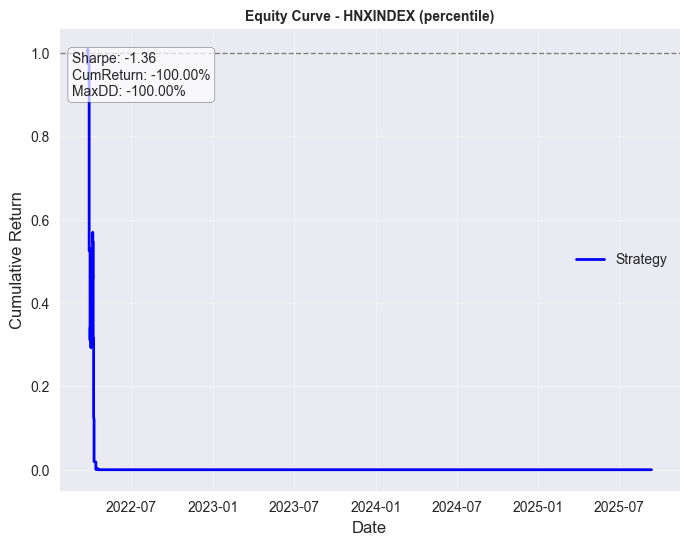

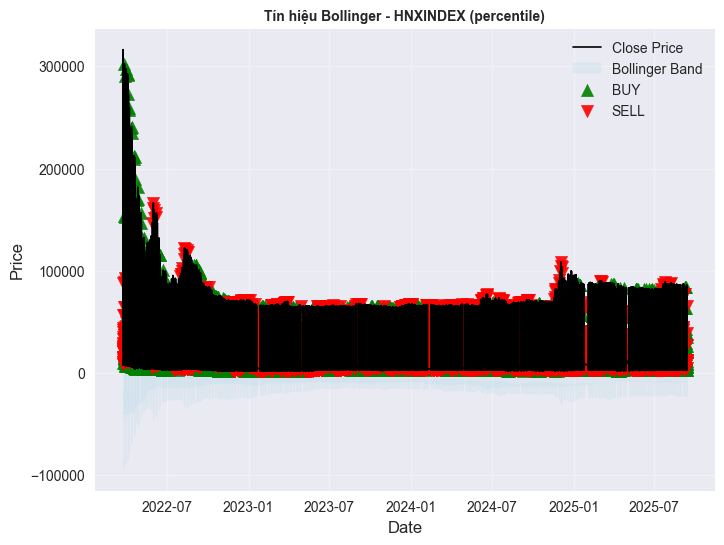


>>> Sàn UPCOM - phương pháp percentile (Sharpe=-1.27, CumRet=-100.00%, MDD=-100.00%)


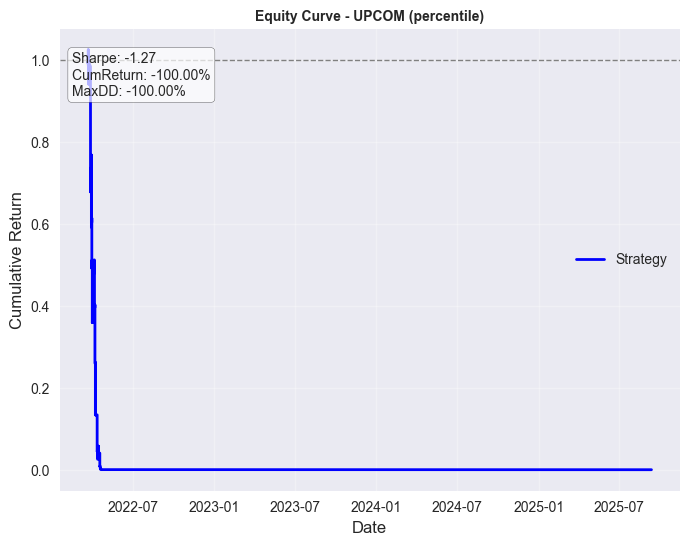

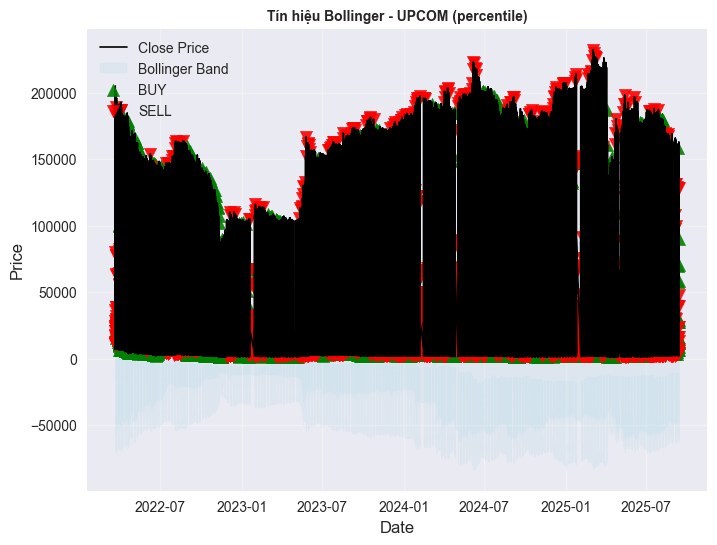


>>> Sàn VNINDEX - phương pháp percentile (Sharpe=-1.37, CumRet=-100.00%, MDD=-100.00%)


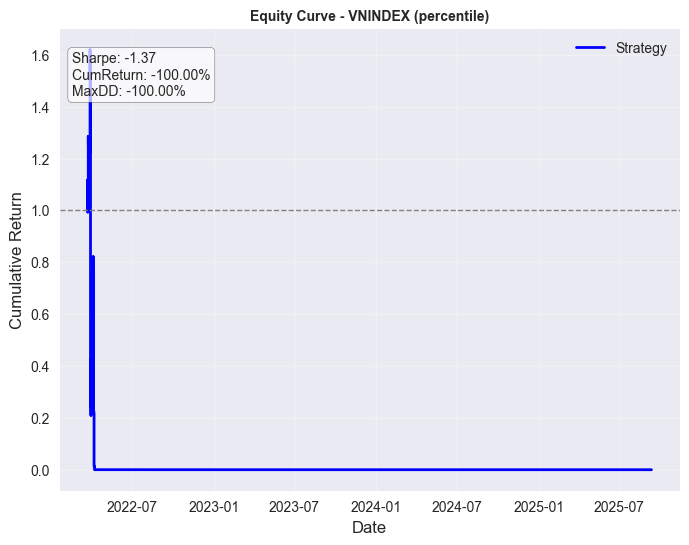

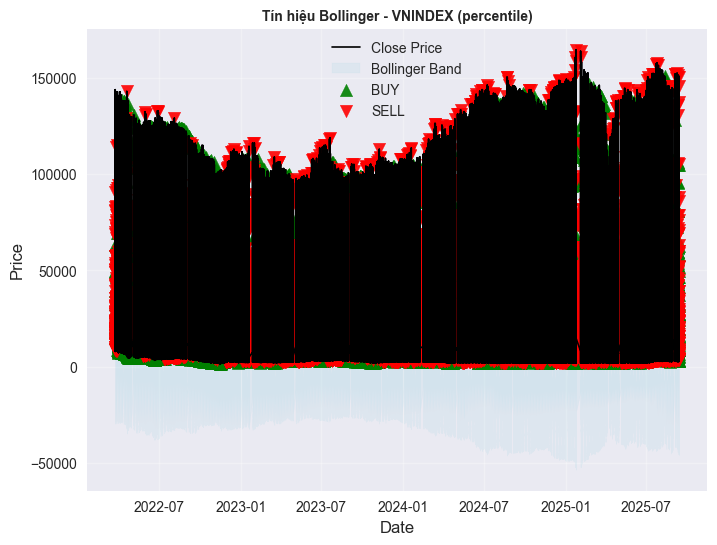

In [10]:
plt.style.use("seaborn-v0_8")

for exchange in df_results['exchange'].unique():
    df_ex = df_results[df_results['exchange'] == exchange]

    # Chọn theo Sharpe ratio
    best = df_ex.loc[df_ex['sharpe'].idxmax()]
    df_best = best['df']

    sharpe = best['sharpe']
    cum_return = best['cum_return']
    max_dd = best['max_drawdown']

    print(f"\n>>> Sàn {exchange} - phương pháp {best['method']} (Sharpe={sharpe:.2f}, CumRet={cum_return:.2%}, MDD={max_dd:.2%})")

    # ----- Equity Curve -----
    plt.figure(figsize=(8,6))
    plt.plot(df_best['timestamp'], df_best['cum_return'], label="Strategy", color="blue", linewidth=2)
    plt.axhline(1, color="gray", linestyle="--", linewidth=1)

    plt.title(f"Equity Curve - {exchange} ({best['method']})", fontsize=10, fontweight="bold")
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Cumulative Return", fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()

    # Thêm text chú thích
    textstr = f"Sharpe: {sharpe:.2f}\nCumReturn: {cum_return:.2%}\nMaxDD: {max_dd:.2%}"
    plt.gca().text(0.02, 0.95, textstr, transform=plt.gca().transAxes,
                   fontsize=10, verticalalignment="top",
                   bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    plt.show()

    # ----- Giá + Tín hiệu BUY/SELL -----
    plt.figure(figsize=(8,6))
    plt.plot(df_best['timestamp'], df_best['close'], label="Close Price", color="black", linewidth=1.2)

    # Bollinger Bands 
    if 'bollinger_bw' in df_best.columns:
        mid = df_best['close'].rolling(20).mean()
        std = df_best['close'].rolling(20).std()
        upper = mid + 2*std
        lower = mid - 2*std
        plt.fill_between(df_best['timestamp'], lower, upper, color="lightblue", alpha=0.2, label="Bollinger Band")

    # BUY / SELL signals
    plt.scatter(df_best.loc[df_best['signal']==1, 'timestamp'],
                df_best.loc[df_best['signal']==1, 'close'],
                marker="^", color="green", label="BUY", alpha=0.9, s=80)
    plt.scatter(df_best.loc[df_best['signal']==-1, 'timestamp'],
                df_best.loc[df_best['signal']==-1, 'close'],
                marker="v", color="red", label="SELL", alpha=0.9, s=80)

    plt.title(f"Tín hiệu Bollinger - {exchange} ({best['method']})", fontsize=10, fontweight="bold")
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()